# Simple Examples of Solving PDE with DL

In [30]:
import time
import math

import torch
from tqdm import trange
from torch import nn, autograd, optim

%matplotlib notebook 
import matplotlib.pyplot as plt

from nets import *
from graphics import *

In [31]:
# Exact solution of the problem {du/dt + a du/dx = 0, u(0, x) = gauss(x), u(t, 0) = gauss(0)}
# Also, it is used here to set initial or boundary conditions in PDEs
alpha = 200.
def dome(x, t=0, a=.5, alpha=alpha, shift=0.):
    if isinstance(t, torch.Tensor):
        t = t[:, None]
    psi = torch.exp(-alpha*torch.tensor(shift**2))
    res = torch.exp(-alpha*(x-shift-a*t)**2)
    out = torch.empty_like(res).fill_(psi.item())
    out[x - a*t > 0] = res[x - a*t > 0]
    
    return out

# Another initial condition
alpha = 10.
def spike(x, alpha=alpha, shift=.5):
    return torch.exp(-alpha*(x-shift).abs())

In [32]:
# Evaluation metrics
max_error = lambda u_exact, u_approx: torch.norm(u_exact - u_approx, p=float('inf'))
avg_error = lambda u_exact, u_approx: torch.mean((u_exact - u_approx)**2)**.5 

## Advection Equation

In [5]:
class PDE2D(nn.Module):
    """
    Base class
    ----------
    Args:
    -----
    l                 length of calculation area along x axis
                      (starting from 0)
    T                 length of calculation area along t axis
                      (starting from 0)

                      Thus, (0, l) x (0, T) is the training domain
    """
    def __init__(self, l=1., T=2.):
        super().__init__()
        self.l = l
        self.T = T
    
    def sampleBatch(self, N=5120, device='cpu'):
        """
        Simple sampler
        Generates pair (t, x), from which one can build the pairs
        (t, x), (t, 0), (0, x)
        Works slightly worse than if these pairs were generated independently
        ----------------------
        N - number of points to sample in the domain (x, t)
        """
        tx = torch.rand(N, 2, device=device)
        tx[:, 0].mul_(self.T)
        tx[:, 1].mul_(self.l)

        return tx
    
    def _D(self, y, x):
        grad = autograd.grad(
            outputs=y, inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True, allow_unused=True)
        
        if len(grad) == 1:
            return grad[0]
        return grad

In [6]:
def init_weights(net, seed):
    torch.manual_seed(seed)
    for p in net.parameters():
        p.data.normal_(1)

class TestLinear(nn.Module):
    def __init__(self, inc, outc):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(inc, outc, bias=False), 
            nn.ELU())
    def forward(self, t, x):
        tx = torch.stack((t, x), 1)
        return self.main(tx)
    
fc1 = nn.Sequential(nn.Linear(2, 1, bias=False), nn.ELU())
fc2 = TestLinear(2, 1)

init_weights(fc1, 123)
init_weights(fc2, 123)

tx = torch.rand(10, 2, requires_grad=True)
t, x = torch.unbind(tx, 1)
D = torch.randn_like(x)
xpD = x + D

y1 = fc1(tx)
y2 = fc2(t, x+D)
y3 = fc2(t, xpD**2)
y = fc2(t, x**2)
out1 = autograd.grad(y1, x, torch.ones_like(y), create_graph=True, allow_unused=True)
out2 = autograd.grad(y2, x+D, torch.ones_like(y), create_graph=True, allow_unused=True)
out3 = autograd.grad(y3, xpD, torch.ones_like(y), create_graph=True, allow_unused=True)
out4 = autograd.grad(y3, x, torch.ones_like(y), create_graph=True, allow_unused=True)

out = autograd.grad(y, x, torch.ones_like(y), create_graph=True, allow_unused=True)

print('OUT1:', out1)
print('---------')
print('OUT2:', out2)
print('---------')
print('OUT3:', out3)
print('---------')
print('OUT4:', out4)
print()
print('OUT:', out)

OUT1: (None,)
---------
OUT2: (None,)
---------
OUT3: (tensor([ 2.4681,  1.7203,  2.4183,  3.7194,  0.3541, -1.0853,  0.7988,  0.5234,
         1.2656,  5.3882], grad_fn=<MulBackward0>),)
---------
OUT4: (tensor([ 2.4681,  1.7203,  2.4183,  3.7194,  0.3541, -1.0853,  0.7988,  0.5234,
         1.2656,  5.3882], grad_fn=<MulBackward0>),)

OUT: (tensor([1.9416, 0.2296, 1.6278, 1.5396, 0.4406, 0.9002, 1.8540, 1.4800, 1.3291,
        2.2018], grad_fn=<MulBackward0>),)


In [7]:
class AdvectionPDE(PDE2D):
    """
    Homogeneous Advection Equation
    -------------------------------------
    du/dt + a du/dx = 0
    u(0, x) = gauss(x)
    u(t, 0) = gauss(0)
    -------------------------------------
    Args:
    -----
    a                 wave velocity
    """
    def __init__(self, a=.5, l=1., T=2.):
        super().__init__(l, T)
        self.a = a

    def computeLoss(self, tx, net):
        t, x = torch.unbind(tx, 1)
        o = torch.zeros_like(t)
        u_t, u_x = self._D(net(t,x), (t,x))
        L = (torch.norm(u_t + self.a * u_x)
             + torch.norm(net(o, x) - dome(x, shift=.25))
             + torch.norm(net(t, o) - dome(x.new(1).fill_(0.), shift=.25)))
            
        return L

In [8]:
def train(net, pde, optimizer, loss_history, batch_size=5120):
    for _ in trange(num_batches, desc='Training'):
        optimizer.zero_grad()
     
        batch = pde.sampleBatch(batch_size, device)
        batch.requires_grad_(True)
     
        loss = pde.computeLoss(batch, net)
        loss_history.append(loss.item())
        loss.backward()
     
        optimizer.step()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e4)

pde = AdvectionPDE()
# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain

#net = DGM(d=1, M=50, L=3).to(device)
net = DumbLinear('3l', base_width=128).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(solver,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters())
loss_history = []

You have 0 gpus


In [11]:
try:
    train(net, pde, optimizer, loss_history, 128)
except KeyboardInterrupt:
    pass

Training: 100%|██████████| 10000/10000 [02:35<00:00, 64.25it/s]


<IPython.core.display.Javascript object>


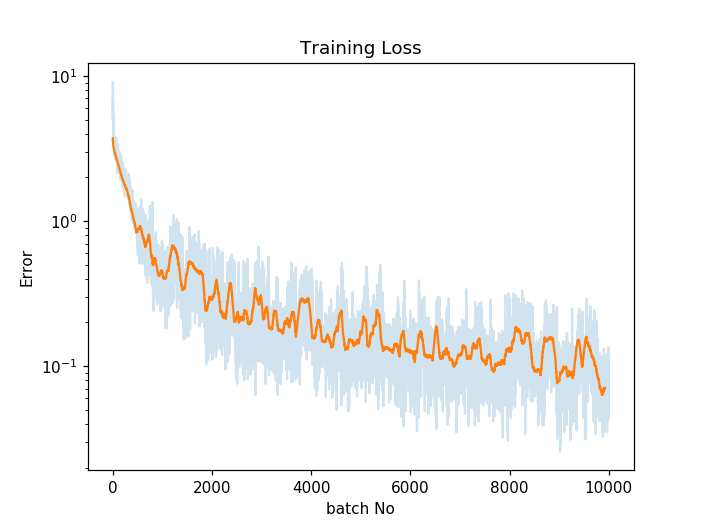

In [12]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');

### Initial condition approximation

max error 0.006482630968093872
avg error 0.0024335086345672607


<IPython.core.display.Javascript object>


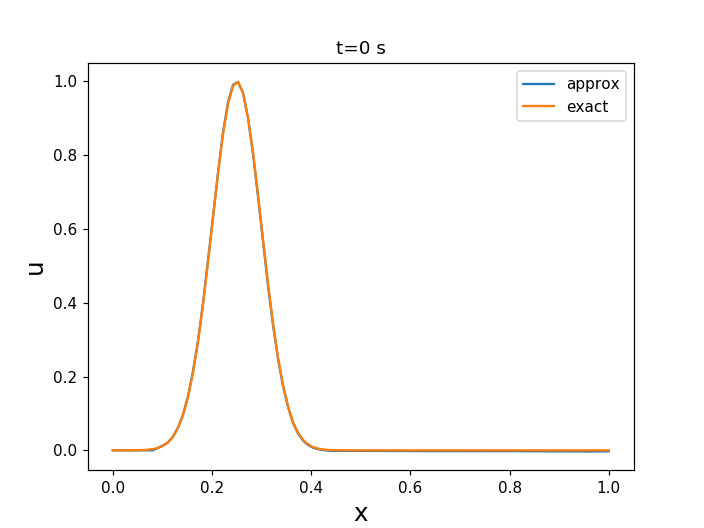

In [23]:
x = torch.linspace(0, 1, device=device)
o = torch.zeros_like(x)

y_true = dome(x, shift=.25)
y = net(o, x).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu().numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('t=0 s')
plt.legend();

### Approximation at time `t`

max error 0.010989606380462646
avg error 0.0033499523997306824


<IPython.core.display.Javascript object>


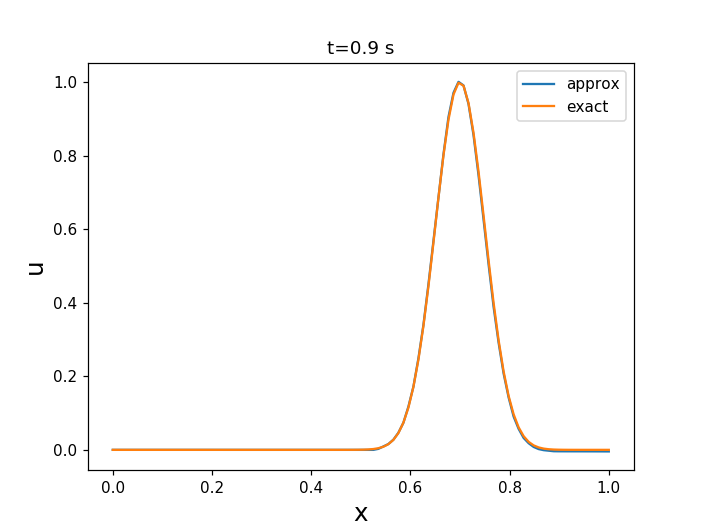

In [24]:
t_val = .9 
x = torch.linspace(0, 1, device=device)
t = torch.empty_like(x).fill_(t_val)

y_true = dome(x, t_val, shift=.25)
y = net(t, x).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu().numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();

### Run cell to start animating
if there is only one graph, re-run the cell

---
As expected, the approximation is fairly good on the training data, and when the model encounters test data the solutions begin to diverge

<IPython.core.display.Javascript object>


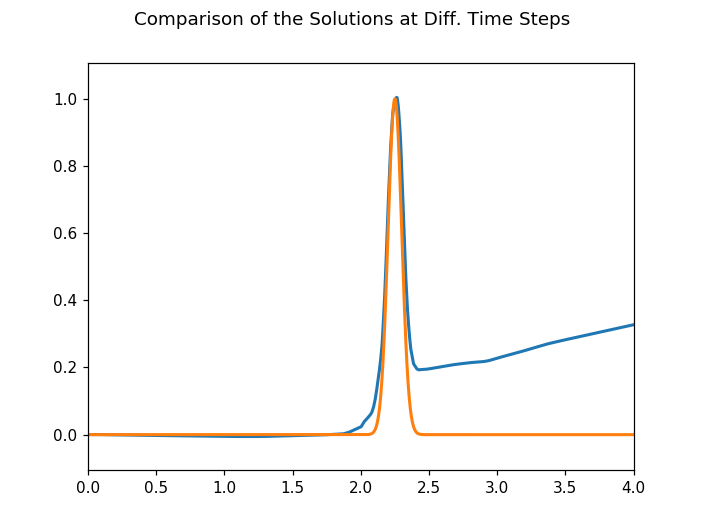

In [16]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t, shift=.25)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(len(t), -1)
y = net(t.to(device), x.to(device)).view(len(x), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

---
## Numerical Solution
finite-difference and nonstandard finite-difference methods

$$
\left\{\begin{aligned}
    &u_i^{n+1} = u_i^n + a\Delta t (u_{i-1}^n- u_i^n)\\
    &u_i^0 = \exp(-\alpha(i\Delta h - 0.25)^2)\\
    &u_0^n = 0
\end{aligned}\right.
$$

In [15]:
l = 1
T = 1
o = torch.zeros(1, device=device)
dx = 1e-3
rdx = 1 / dx
dt = 2e-3
a = .5

x = torch.linspace(0, l, int(l/dx))
u_0x = dome(x, shift=.25)
u_exact = dome(x, t=T, a=a, shift=.25)

def one_time_step(u):
    return u + torch.cat([o, -a*dt*rdx * (u[1:] - u[:-1])])

In [16]:
u1 = u_0x
for i in range(int(.5 * T / dt)):
    u2 = one_time_step(u1)
    u1 = one_time_step(u2)

<IPython.core.display.Javascript object>


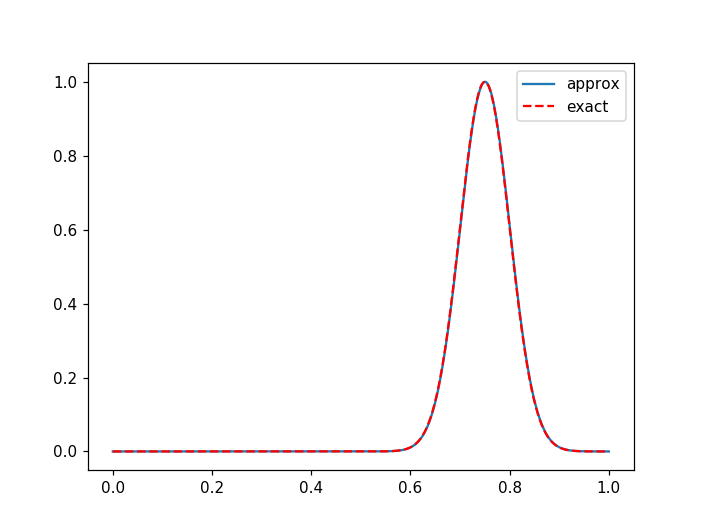

max error 0.0060707926750183105
avg error 0.0021060598082840443


In [17]:
plt.figure()
print('max error', max_error(u_exact, u1).item())
print('avg error', avg_error(u_exact, u1).item())
plt.plot(x.numpy(), u1.numpy(), label='approx')
plt.plot(x.numpy(), u_exact.numpy(), '--r', label='exact')
plt.legend();

---
* **Case 1**
$$
\left\{\begin{aligned}
    &u_t - u\,u_{xx} = u(1-u), &&\quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = 0, &&\quad x \in (0,l]\\
    &u(t, 0) = 1, &&\quad t \in [0,T]\\
    &u(t, l) = 0, &&\quad t \in [0,T]\\
    &0 \le u(t, x) \le 1\\
\end{aligned}\right.
$$

**Nonstandard Finite Difference Method (NSFDM)** for the problem above

$$
    \frac{u^{n+1}_m - u^n_m}{\phi(\Delta t)}
    = u^{n+1}_m \left[\frac{u^n_{m+1} - 2u^n_m + u^n_{m-1}}{\psi(\Delta x)}\right]
    + 2\bar u^n_m - u^{n+1}_m - u^{n+1}_m \bar u^n_m
$$

$$
    \bar u^n_m \equiv \frac{u^n_{m+1} + u^n_{m-1}}{2}
$$

One can check that this scheme is stable (considering that initial values of $0 < u < 1$)
if $\frac{\phi(\Delta t)}{\psi(\Delta x)} \lt \frac{1}{2}$ (without any spectral analysis).
The stability condition might be or might be not weakened, if analyzed more thoroughly

Here, the 'denominator function' (calling such both $\psi$ and $\phi$ in general) satisfies:

$$
    \varphi(h, \lambda) = h + O(h^2)
$$

$\lambda$ is some hyperparameter that might appear in PDEs (as an example of $\varphi$ you can consider $\exp(\bullet) - 1$)  
For the sake of simplicity, we can take $\quad\phi(\Delta t) = \Delta t, \qquad \psi(\Delta x) = (\Delta x)^2$  
What else is worth mentioning here is that terms $u$ and $u^2$ are discretized non-locally
($u \to 2\bar u^n_m - u^{n+1}_m$ instead of just $u^n_m$, and likewise, $u^2 \to u^{n+1}_m\bar u^n_m$)  
Local discretization in turn prevents the propagation of diffusion process (see in [the paper](https://core.ac.uk/download/pdf/82343686.pdf) how)

This scheme is explicit, so we can write
$$
    u^{n+1}_m = \frac{u^n_m + 2\phi\bar u^n_m}{1+ \phi + \frac{2\phi}{\psi}(u^n_m - \bar u^n_m)+\phi\bar u^n_m}
$$

* **Case 2**

Also, we can consider similar problem:

$$
\left\{\begin{aligned}
    &u_t - a\,u_{xx} = ru(1-u), &&\quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = \mathrm{dome}(x), &&\quad x \in [0,l]\\
    &u(t, 0) = \mathrm{dome}(0), &&\quad t \in [0,T]\\
    &u(t, l) = \mathrm{dome}(l), &&\quad t \in [0,T]\\
    &0 \le u(t, x) \le 1\\
\end{aligned}\right.
$$

For this problem formulation, we can write the following explicit scheme:

$$
    u^{n+1}_m = \frac{(1 - \frac{2a\phi}{\psi})u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m}
    {1 + r\phi\bar u^n_m}
$$

With simple stability analysis, we have $\frac{2a\phi(\Delta t)}{\psi(\Delta x)} \lt 1$:  

$$
    u^{n+1}_m \ge 0 \quad\longrightarrow\quad \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m \ge 0, \quad\forall u^n_m, \bar u^n_m \in [0, 1]\\
    \Longrightarrow 1 - \frac{2a\phi}{\psi} \ge 0
$$

$$
    u^{n+1}_m \le 1 \quad\longrightarrow\quad \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m + r\phi\bar u^n_m \;\le\; 1 + r\phi\bar u^n_m\\
    \left(1 - \frac{2a\phi}{\psi}\right)u^n_m + \frac{2a\phi}{\psi}\bar u^n_m \;\le\; 1, \quad\forall u^n_m, \bar u^n_m \in [0, 1]\\
$$

Considering all possible $u^n_m, \bar u^n_m \in [0, 1]$, we come to the condition above

In [33]:
l = 1.
T = .09
r = 0.
#u_o = dome(torch.zeros(1, device=device), shift=.5)
#u_l = dome(l*torch.ones(1, device=device), shift=.5)
u_o = spike(torch.zeros(1, device=device), shift=.5)
u_l = spike(l*torch.ones(1, device=device), shift=.5)

dx = 1e-3
dt = 4e-6
a = .1

C1 = a*dt/dx/dx
C2 = r*dt

assert C1 < .5

x = torch.linspace(0, l, int(l/dx))
#u_0x = dome(x, shift=.5)
u_0x = spike(x, shift=.5)

def one_time_step(u):
    bar_u = .5 * (u[2:] + u[:-2])
    out = (u[1:-1] + 2*C1*(bar_u-u[1:-1]) + C2*bar_u) / (1 + C2*bar_u)
    return torch.cat([u_o, out, u_l])

In [34]:
u1 = u_0x
for i in range(int(.5*T/dt)):
    u2 = one_time_step(u1)
    u1 = one_time_step(u2)

<IPython.core.display.Javascript object>


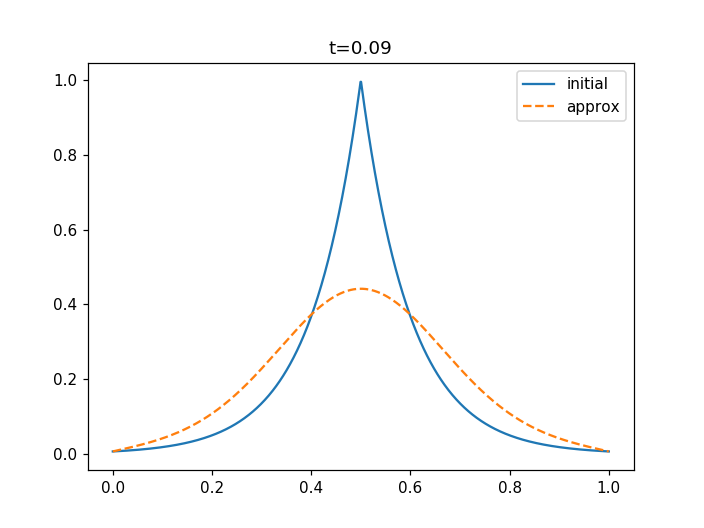

In [35]:
plt.figure()
plt.plot(x.numpy(), u_0x.numpy(), label='initial')
plt.plot(x.numpy(), u1.numpy(), '--', label='approx')
plt.title(f't={T}')
plt.legend();

* **Analytical solution for $r=0$**
$$\left\{\begin{aligned}
    &u_t - a\,u_{xx} = 0, &&\quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = e^{-\alpha |x-\frac{l}{2}|}, &&\quad x \in [0,l]\\
    &u(t, 0) = e^{-\alpha \frac{l}{2}}, &&\quad t \in [0,T]\\
    &u(t, l) = e^{-\alpha \frac{l}{2}}, &&\quad t \in [0,T]\\
\end{aligned}\right.$$

---
Zero the boundary conditions by:
    $$u = v + e^{-\alpha\frac{l}{2}}$$
    
Which gives:
$$\left\{\begin{aligned}
    &v_t - a\,v_{xx} = 0, &&\quad (t,x) \in [0,T]\times[0, l]\\
    &v(0, x) = e^{-\alpha |x-\frac{l}{2}|} - e^{-\alpha\frac{l}{2}}, &&\quad x \in [0,l]\\
    &v(t, 0) = 0, &&\quad t \in [0,T]\\
    &v(t, l) = 0, &&\quad t \in [0,T]\\
\end{aligned}\right.$$

---
Seeking the solution in the form $u \sim \sum_k \Theta_k(t)X_k(x)$.  
The spatial basis' functions are eigenfunctions of the operator $-\frac{d^2}{dx^2}$:

$$
    X_k(x) = \sin\frac{\pi k}{l} x, \quad k = \overline{1, \infty}
$$

Expand $v(0, x)$ in the basis of $X_k$:

$$
    -\frac{2}{l}e^{-\alpha\frac{l}{2}}\int_0^l \sin\frac{\pi k}{l}x\;dx
    =\color{red}{\frac{2}{\pi k}e^{-\alpha\frac{l}{2}}\big(\cos\pi k - 1\big)}\\
    \frac{2}{l}\int_0^l e^{-\alpha |x-\frac{l}{2}|}\sin\frac{\pi k}{l}x\;dx
    = \frac{2}{l}\int_0^\frac{l}{2} e^{\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
    + \frac{2}{l}\int_\frac{l}{2}^l e^{-\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
$$

&nbsp;&nbsp;

$$
    J_1 = \frac{2}{l}\int_0^\frac{l}{2} e^{\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx = 
    \frac{2}{\pi k}\int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;\bigg|_0^\frac{\pi k}{2}
    -\frac{2}{\alpha l}\int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2 \pi k}{(\alpha l)^2}e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;\bigg|_0^\frac{\pi k}{2}
    -\left(\frac{\pi k}{\alpha l}\right)^2\frac{2}{\pi k}
    \int_0^\frac{\pi k}{2} e^{\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}-\frac{2 \pi k}{(\alpha l)^2}\cos\frac{\pi k}{2}
    +\frac{2 \pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}
    -\left(\frac{\pi k}{\alpha l}\right)^2 J_1
$$

&nbsp;&nbsp;

$$
    J_2 = \frac{2}{l}\int_\frac{l}{2}^l e^{-\alpha (x-\frac{l}{2})}\sin\frac{\pi k}{l}x\;dx
    = \frac{2}{\pi k}\int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k}(y-\frac{\pi k}{2})}\sin y\;dy\\
    =-\frac{2}{\alpha l}e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;\bigg|_\frac{\pi k}{2}^{\pi k}
    +\frac{2}{\alpha l}\int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\cos y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2\pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{\pi k}
    (y-\frac{\pi k}{2})}\cos y\;\bigg|_\frac{\pi k}{2}^{\pi k}
    -\left(\frac{\pi k}{\alpha l}\right)^2\frac{2}{\pi k}
    \int_\frac{\pi k}{2}^{\pi k} e^{-\frac{\alpha l}{\pi k} (y-\frac{\pi k}{2})}\sin y\;dy\\
    =\frac{2}{\alpha l}\sin\frac{\pi k}{2}
    -\frac{2\pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}\cos\pi k
    +\frac{2\pi k}{(\alpha l)^2}\cos \frac{\pi k}{2}
    -\left(\frac{\pi k}{\alpha l}\right)^2 J_2
$$

&nbsp;&nbsp;

$$
    J = J_1 + J_2 =  \frac{4}{\alpha l}\sin\frac{\pi k}{2}
    +\frac{2 \pi k}{(\alpha l)^2}e^{-\frac{\alpha l}{2}}(1 -\cos\pi k)
    -\left(\frac{\pi k}{\alpha l}\right)^2 (J_1 + J_2)\\
    J = \color{red}{\frac{4\alpha l\sin\frac{\pi k}{2}
    + 2\pi k e^{-\frac{\alpha l}{2}}(1 -\cos\pi k)}{\alpha^2l^2 + \pi^2k^2}}
$$

---
Frame the problem for the temporal part:

$$\left\{\begin{aligned}
    &\theta_k\,'(t) + \lambda_k a\;\theta_k(t) = 0, \quad t \in [0,T]\\
    &\theta_k(0) = A_k \\
\end{aligned}\right.$$

$$\theta_k(t) = A_ke^{-\lambda_k at}$$
Here $A_k$ is the sum of red expressions calculated above, and $\lambda_k = \left(\frac{\pi k}{l}\right)^2$  
Ultimately, we have for $v$:
$$u(t, x) = \sum_{k=1}^\infty A_ke^{-\lambda_k at} \sin\sqrt{\lambda_k} x$$

$$
    A_{2m} = 0\\
    A_{2m+1} = 4\frac{(-1)^m\alpha l + \pi(2m+1) e^{-\frac{\alpha l}{2}}}{\alpha^2l^2 + \pi^2(2m+1)^2}
    - \frac{4}{\pi (2m+1)}e^{-\frac{\alpha l}{2}}
$$

And for $u$:
$$u(t, x) = e^{-\alpha\frac{l}{2}} + \sum_{m=0}^\infty A_{2m+1}e^{-\lambda_{2m+1}at} \sin\sqrt{\lambda_{2m+1}} x$$

In [36]:
def T_k(t, m):
    """
    k = 2m + 1
    """
    A_k = 4*(((-1)**m*alpha*l + np.pi*(2*m+1)*math.exp(-alpha*l/2))
           / ((alpha*l)**2 + (np.pi*(2*m+1))**2)
           - 1./(np.pi*(2*m+1))*math.exp(-alpha*l/2))
    
    return A_k * torch.exp(-((2*m+1)*np.pi/l)**2 * a*t)
           
def X_k(x, k):
    return torch.sin(np.pi*k/l*x)
    
def sol(t, x, eps=1e-4):
    m = 0
    out = x.new(len(t), len(x)).fill_(0)
    while True:
        coeff = T_k(t, m)
        out += coeff[:, None]*X_k(x, 2*m+1)
        # if-branch can be improved
        if abs(coeff.max()) < eps:
            break
        m += 1
    return math.exp(-alpha*l/2) + out

<IPython.core.display.Javascript object>


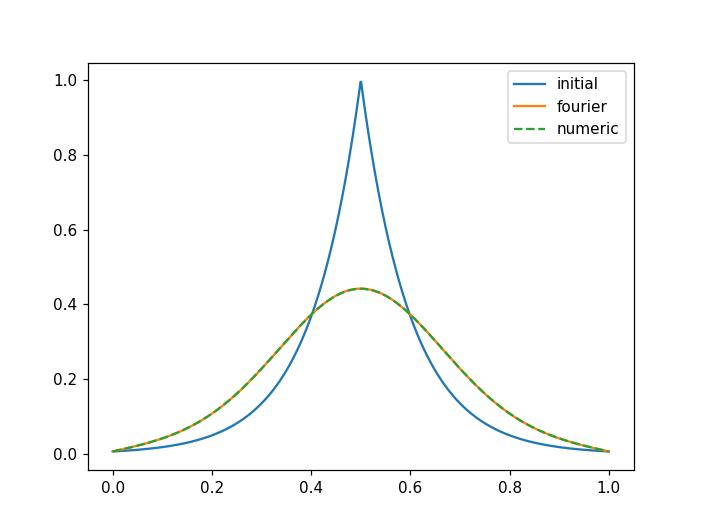

In [37]:
x = l*torch.linspace(0, 1, 1000)
t = torch.tensor([0.09])
plt.figure()
plt.plot(x, spike(x), label='initial')
plt.plot(x, sol(t, x)[0], label='fourier')
plt.plot(x, u1, '--', label='numeric')
plt.legend();

## Fisher Equation

In [38]:
class FisherPDE(PDE2D):
    """
    u_t - a u_xx = r u(1-u)
    u(0, x) = gauss(x)
    u(t, 0) = gauss(0)
    u(t, l) = gauss(1)
    ----------
    Args:
    -----
    a             diffusion coefficient
    r             some other coefficient
    """
    def __init__(self, a=.1, r=0., l=1., T=1.):
        super().__init__(l, T)
        self.a = a
        self.r = r
        
    def computeLoss(self, tx, net, delta=.001):
        t, x = torch.unbind(tx, 1)
        o = torch.zeros_like(t)
        l = torch.empty_like(x).fill_(self.l)
        
        D1 = delta * torch.randn_like(x)
        D2 = delta * torch.randn_like(x)
        
        y0 = net(t, x)
        u_t, u_x = self._D(y0, (t,x))
        
        xpD1 = x + D1
        xpD2 = x + D2
        xmD1 = x - D1
        xmD2 = x - D2
        
        u1_xx_1p = 1./delta * (self._D(net(t, xpD1), xpD1) - u_x) * D1
        u2_xx_1p = 1./delta * (self._D(net(t, xpD2), xpD2) - u_x) * D2
        u1_xx_1m = 1./delta * (self._D(net(t, xmD1), xmD1) - u_x) * D1
        u2_xx_1m = 1./delta * (self._D(net(t, xmD2), xmD2) - u_x) * D2
#         u_xx = u1_xx_1p + u1_xx_1m
        
#         u1_xx_1p = 1./delta * (self._D(net(t, x+D1), x) - u_x) * D1
#         u2_xx_1p = 1./delta * (self._D(net(t, x+D2), x) - u_x) * D2
#         u1_xx_1m = 1./delta * (self._D(net(t, x-D1), x) - u_x) * D1
#         u2_xx_1m = 1./delta * (self._D(net(t, x-D2), x) - u_x) * D2
        
        eq_res_1p = ((u_t - self.a*u1_xx_1p - self.r*y0*(1-y0)).detach()
                     *(u_t - self.a*u2_xx_1p - self.r*y0*(1-y0)))
        eq_res_1m = ((u_t + self.a*u1_xx_1m - self.r*y0*(1-y0)).detach()
                     *(u_t + self.a*u2_xx_1m - self.r*y0*(1-y0)))
        
        # Should I take .abs() here, in the sum?
        L = (torch.mean((eq_res_1p + eq_res_1m).abs())
             + torch.norm(net(o, x) - spike(x, shift=.5))
             + torch.norm(net(t, o) - spike(x.new(1).fill_(0.), shift=.5*self.l))
             + torch.norm(net(t, l) - spike(x.new(1).fill_(self.l), shift=.5*self.l)))
#         print(torch.norm(u_t - self.a*u_xx - self.r*y0*(1-y0)))
#         print(torch.norm(net(o, x) - spike(x)))
#         print(torch.norm(net(t, o) - spike(x.new(1).fill_(0.))))
#         print(torch.norm(net(t, l) - spike(x.new(1).fill_(self.l))))
#         print(torch.sum((eq_res_1p + eq_res_1m)))
#         print('----')
#         L = (torch.norm(u_t - self.a*u_xx-self.r*y0*(1-y0))
#              + torch.norm(net(o, x) - spike(x))
#              + torch.norm(net(t, o) - spike(x.new(1).fill_(0.)))
#              + torch.norm(net(t, l) - spike(x.new(1).fill_(self.l))))
#         print(L)
#         print('=======')
        
        return L
    
######################################################
###########  Without variance reduction  #############
######################################################
#     def computeLoss(self, tx, net, delta=.001):
#         t, x = torch.unbind(tx, 1)
#         o = torch.zeros_like(t)
#         l = torch.empty_like(x).fill_(self.l)
        
#         D1 = delta * torch.randn_like(x)
#         D2 = delta * torch.randn_like(x)
        
#         y0 = net(t, x)
#         u_t, u_x = self._D(y0, (t,x))
        
#         xpD1 = x + D1
#         xpD2 = x + D2
        
#         u1_xx = 1./delta * (self._D(net(t, xpD1), xpD1) - u_x) * D1
#         u2_xx = 1./delta * (self._D(net(t, xpD2), xpD2) - u_x) * D2
        
#         eq_res= ((u_t - self.a*u1_xx- self.r*y0*(1-y0)).detach()
#                      *(u_t - self.a*u2_xx- self.r*y0*(1-y0)))
        
#         L = (torch.sum(eq_res)
#              + torch.norm(net(o, x) - dome(x))
#              + torch.norm(net(t, o) - dome(x.new(1).fill_(0.)))
#              + torch.norm(net(t, l) - dome(x.new(1).fill_(self.l))))
        
#         return L

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e5)

pde = FisherPDE()
# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain

# net = DGM(d=1, M=50, L=3).to(device)
net = DumbLinear('3l', base_width=128).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(solver,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_history = []

You have 0 gpus


In [55]:
try:
    train(net, pde, optimizer, loss_history, 512)
except KeyboardInterrupt:
    pass

Training:   4%|▎         | 3552/100000 [04:03<2:15:34, 11.86it/s]

<IPython.core.display.Javascript object>


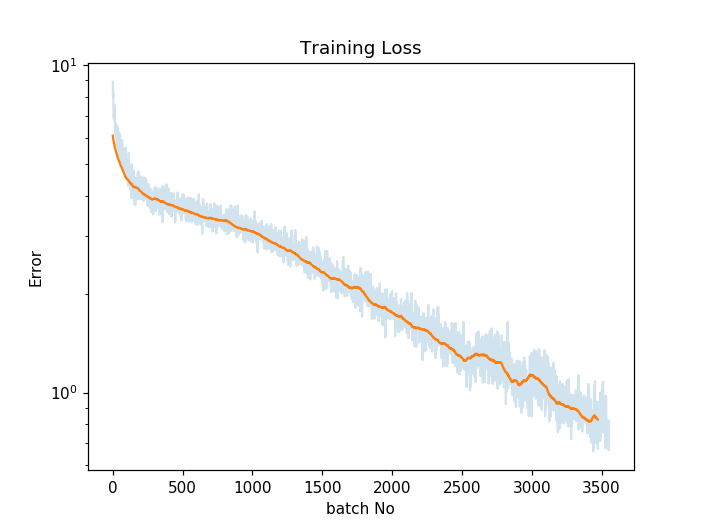

In [56]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');

<IPython.core.display.Javascript object>


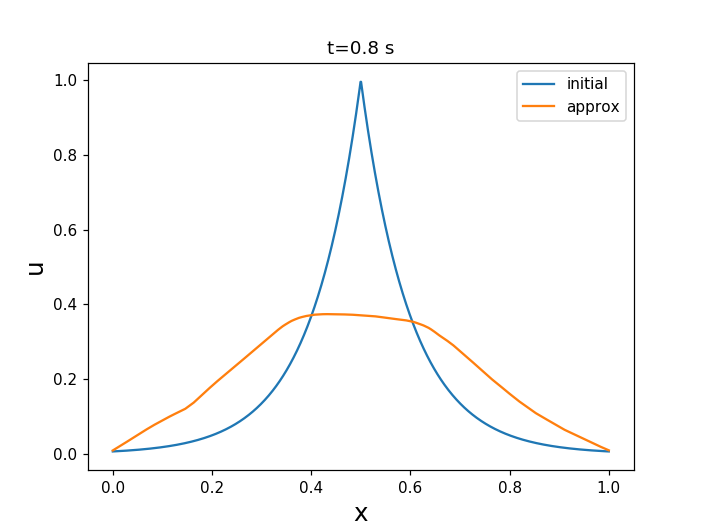

In [57]:
t_val = 0.8
x = torch.linspace(0, 1, 1000, device=device)
t = torch.empty_like(x).fill_(t_val)

y = net(t, x).detach().cpu()
y_initial = spike(x, shift=.5)
# print('max error', max_error(y_true, y).item())
# print('avg error', avg_error(y_true, y).item())
x = x.cpu().numpy()

plt.figure() 
plt.plot(x, y_initial, label='initial')
plt.plot(x, y.numpy(), label='approx')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();

---
## Draft

Testing [PyDEns](https://github.com/analysiscenter/pydens) library

In [2]:
import tensorflow as tf
from pydens import Solver, NumpySampler, add_tokens, cart_prod
add_tokens()

/home/lukoshkin/BuildPacks/miniconda3/envs/SR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lukoshkin/BuildPacks/miniconda3/envs/SR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lukoshkin/BuildPacks/miniconda3/envs/SR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lukoshk

In [ ]:
# Exact solution of the problem {du/dt + a du/dx = 0, u(0, x) = gauss(x)}
# ! forgot to add the condition at t=0, fix this later
def special(x, alpha=200):
    return tf.exp(-200*(x-.25)**2)

In [4]:
pde = {'n_dims': 2,
       'form': lambda u, t, x: D(u, t) + .5 * D(u, x),
       'initial_condition': lambda x: special(x)}

body = {'layout': 'fa fa f',
        'units': [256, 512, 1],
        'activation': [tf.nn.relu, tf.nn.relu, tf.nn.relu]}

config = {'body': body,
          'pde': pde}

us = NumpySampler('uniform', dim=2)
dg = Solver(config)




Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().




In [5]:
%%time
dg.fit(batch_size=100, sampler=us, n_iters=5000)

CPU times: user 3min 17s, sys: 16.6 s, total: 3min 33s
Wall time: 55.3 s


In [3]:
# plot real solution and network approximation
n_el = 100
sol = lambda t: np.exp(-200*((x-.25) - .5*t)**2)
grid = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))
approxs = dg.solve(grid)
plt.imshow(approxs.reshape(n_el, n_el))
plt.colorbar()
plt.show()

NameError: name 'cart_prod' is not defined

<IPython.core.display.Javascript object>


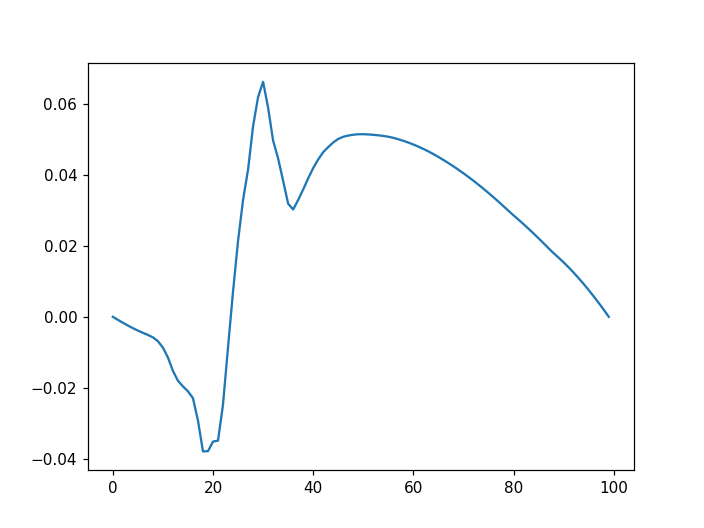

In [9]:
plt.figure()
plt.plot(approxs.reshape(n_el, n_el)[:, 80]);